In [57]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


#dfs = load_data_bq()
dfs = load_data_db()

df_contratos = dfs
df_contratos = df_contratos["dias_agenciados"]

Conexão estabelecida com sucesso!


In [58]:
df_eventos = pd.read_csv(
    "data/Clientes Estratégicos - B2B x Conteúdo Personalizado(base).csv", 
    sep=";", 
    encoding="latin1"  # or "cp1252"
)


df_eventos.columns = ['cnpj', 'ID', 'NOME TRANSPORTADORA(S)', 'Status', 'Tier', 'CONTROLE',
       'CONTEÚDO PERSONALIZADO', 'TELEMETRIA', 'CAVALEIRO', 'TIPO',
       'DIAS DE CONTRATO', 'Data Telemetria', 'Data Conteúdo Personalizado']


In [59]:
df_eventos = df_eventos.fillna(0)

In [60]:
import pandas as pd
import re
df = df_eventos

# Função para limpar a string e converter para lista de inteiros, ignorando itens inválidos
def parse_ids(s):
    # Remove colchetes se houver
    s_clean = re.sub(r'[\[\]]', '', s)
    result = []
    for item in s_clean.split(','):
        item_str = item.strip()
        try:
            result.append(int(item_str))
        except ValueError:
            # Ignora o item se não puder ser convertido para inteiro (ex.: '#N/D')
            continue
    return result

# Cria uma nova coluna com a lista de IDs
df['ID_list'] = df['ID'].apply(parse_ids)

# Explode a coluna 'ID_list' para transformar cada ID em uma nova linha
df_exploded = df.explode('ID_list')

# Descarta a coluna original 'ID' para evitar duplicidade
df_exploded = df_exploded.dropna(axis=0)
df_exploded = df_exploded.drop(columns=['ID'])

# Renomeia a coluna explode para "ID"
df_exploded = df_exploded.rename(columns={'ID_list': 'ID'})

# Converte a coluna de ID para inteiro (agora todos os valores são provenientes da lista)
df_exploded['ID'] = df_exploded['ID'].astype(int)



df_contratos = df_contratos.merge(df_exploded, left_on="company_id", right_on="ID")


# Exibe o DataFrame resultante
df_contratos.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID
0,2023-04-28 15:50:15,423,1.0,16661925,OPERAÇÕES AMBEV,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,33,0,0,423
1,2023-05-10 14:20:02,347,17.0,20682,TRANSPORTADORA SIDER LTDA,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,369,0,0,347
2,2022-11-28 16:22:58,335,12.0,23850588,TRANSPANORAMA,Recorrente,2,Não,Sim,Não,GALAHAD,Cliente Estratégico,347,0,25/09/2024,335
3,2022-11-28 16:37:00,159,21.0,29081265,G2L LOGISTICA,Recorrente,4,Não,Não,Sim,GALAHAD,Cliente Estratégico,1227,02/02/2024,0,159
4,2022-09-28 17:33:41,249,5.0,23850588,TOZZO,Recorrente,2,Não,Sim,Sim,CONSTANTINE,Cliente Estratégico,885,21/06/2024,29/08/2024,249


/tmp/ipykernel_50230/2334186229.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ['company_id', pd.Grouper(key='created_at', freq='M')]
/tmp/ipykernel_50230/2334186229.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ['company_id', pd.Grouper(key='created_at', freq='M')]


,company_id,media_contratos_antes_telemetria,media_contratos_depois_telemetria
0,27,27.115385,29.000000
1,34,13.862069,29.000000
2,131,19.047619,28.800000
3,150,9.037037,1.500000
4,159,28.500000,46.769231


,company_id,media_contratos_antes_telemetria,media_contratos_depois_telemetria
count,65.000000,54.000000,60.000000
mean,1861.430769,18.102910,27.903357
std,1220.373598,20.633256,28.802065
min,27.000000,2.333333,1.000000
25%,598.000000,4.407143,6.750000
50%,2124.000000,10.033333,17.380952
75%,2886.000000,22.176692,47.451923
max,3916.000000,108.250000,130.750000


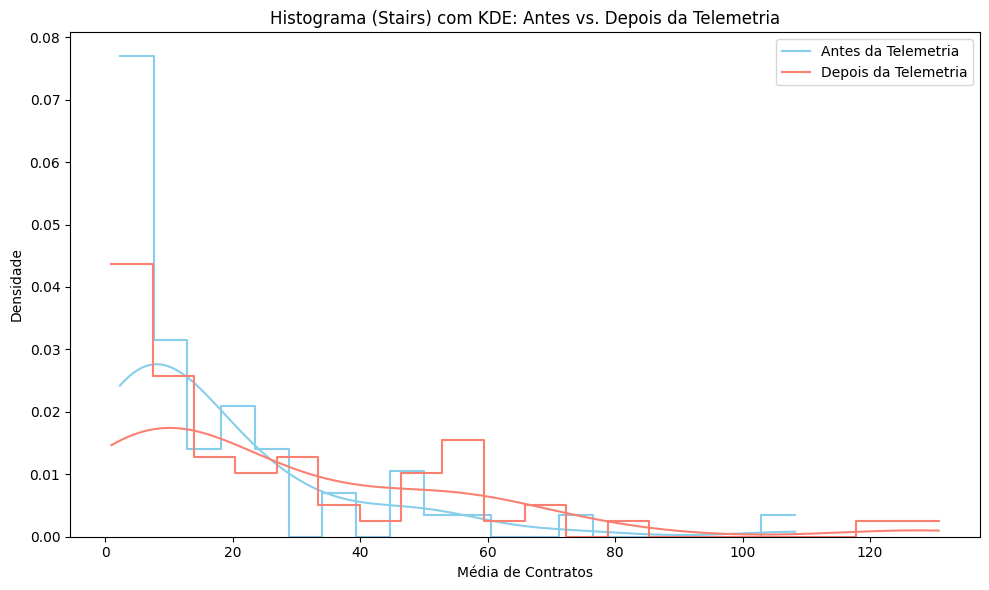

In [61]:
import pandas as pd

# Cópia do DataFrame original
df = df_contratos.copy()

# Converter as colunas para datetime
df['Data Telemetria'] = pd.to_datetime(df['Data Telemetria'], errors='coerce', dayfirst=True)
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# --- Contratos ANTES da Telemetria ---
# Criar máscara para registros onde created_at é menor que Data Telemetria
mask_antes = df['created_at'] < df['Data Telemetria']
df_antes = df[mask_antes]

# Agrupar por company_id e mês (baseado em created_at)
contratos_mensais_antes = df_antes.groupby(
    ['company_id', pd.Grouper(key='created_at', freq='M')]
).size().reset_index(name='num_contratos')

# Calcular a média de contratos por mês para cada company_id (antes da telemetria)
media_antes = contratos_mensais_antes.groupby('company_id')['num_contratos'].mean().reset_index()
media_antes.rename(columns={'num_contratos': 'media_contratos_antes_telemetria'}, inplace=True)

# --- Contratos DEPOIS da Telemetria ---
# Criar máscara para registros onde created_at é maior que Data Telemetria 
# e Data Telemetria não é 1970-01-01 (valor inválido)
mask_depois = (df['created_at'] > df['Data Telemetria']) & \
              (df['Data Telemetria'] != pd.to_datetime('1970-01-01'))
df_depois = df[mask_depois]

# Agrupar por company_id e mês (baseado em created_at)
contratos_mensais_depois = df_depois.groupby(
    ['company_id', pd.Grouper(key='created_at', freq='M')]
).size().reset_index(name='num_contratos')

# Calcular a média de contratos por mês para cada company_id (depois da telemetria)
media_depois = contratos_mensais_depois.groupby('company_id')['num_contratos'].mean().reset_index()
media_depois.rename(columns={'num_contratos': 'media_contratos_depois_telemetria'}, inplace=True)

# --- Unir os resultados ---
# Se alguma empresa tiver apenas contratos antes ou apenas depois, usaremos merge outer
media_contratos = pd.merge(media_antes, media_depois, on='company_id', how='outer')

# Visualizar resultados
display(media_contratos.head())
display(media_contratos.describe())
media_contratos_telemetria = media_contratos.copy()



import matplotlib.pyplot as plt
import seaborn as sns

# Remover NaNs, se houver
dados_antes = media_contratos['media_contratos_antes_telemetria'].dropna()
dados_depois = media_contratos['media_contratos_depois_telemetria'].dropna()

plt.figure(figsize=(10, 6))

# Plotar o histograma com KDE para "antes" utilizando o formato de stairs (step)
sns.histplot(
    dados_antes, 
    kde=True, 
    bins=20, 
    color='skyblue', 
    element='step',   # desenha como stairs
    fill=False,       # sem preenchimento
    stat="density",   # para normalizar e facilitar a comparação
    label='Antes da Telemetria'
)

# Plotar o histograma com KDE para "depois" utilizando o formato de stairs (step)
sns.histplot(
    dados_depois, 
    kde=True, 
    bins=20, 
    color='salmon', 
    element='step',   # desenha como stairs
    fill=False,       # sem preenchimento
    stat="density",   # para normalizar e facilitar a comparação
    label='Depois da Telemetria'
)

plt.xlabel('Média de Contratos')
plt.ylabel('Densidade')
plt.title('Histograma (Stairs) com KDE: Antes vs. Depois da Telemetria')
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
from scipy.stats import wilcoxon

df = media_contratos.copy()
df = df.dropna(axis=0)

# Supondo que o DataFrame media_contratos possui as colunas:
# 'media_contratos_antes_telemetria' e 'media_contratos_depois_telemetria'
data_antes = df['media_contratos_antes_telemetria']
data_depois = df['media_contratos_depois_telemetria']

# Aplicar o teste de Wilcoxon para amostras pareadas
stat, p_value = wilcoxon(data_antes, data_depois)

print("Estatística do teste de Wilcoxon:", stat)
print("p-valor:", p_value)


Estatística do teste de Wilcoxon: 234.0
p-valor: 0.0002824993571180473


/tmp/ipykernel_50230/2098194168.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ['company_id', pd.Grouper(key='created_at', freq='M')]
/tmp/ipykernel_50230/2098194168.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ['company_id', pd.Grouper(key='created_at', freq='M')]


,company_id,media_contratos_antes_conteudo,media_contratos_depois_conteudo
0,34,14.241379,26.800000
1,36,83.255814,66.142857
2,88,9.727273,NaN
3,131,21.760000,23.000000
4,150,8.517241,1.500000


,company_id,media_contratos_antes_conteudo,media_contratos_depois_conteudo
count,67.000000,61.000000,47.000000
mean,1246.761194,19.115391,26.337280
std,1174.886830,22.693570,24.508258
min,34.000000,1.000000,1.000000
25%,274.500000,7.000000,4.000000
50%,860.000000,10.750000,21.666667
75%,2122.500000,21.760000,48.750000
max,3916.000000,137.333333,72.428571


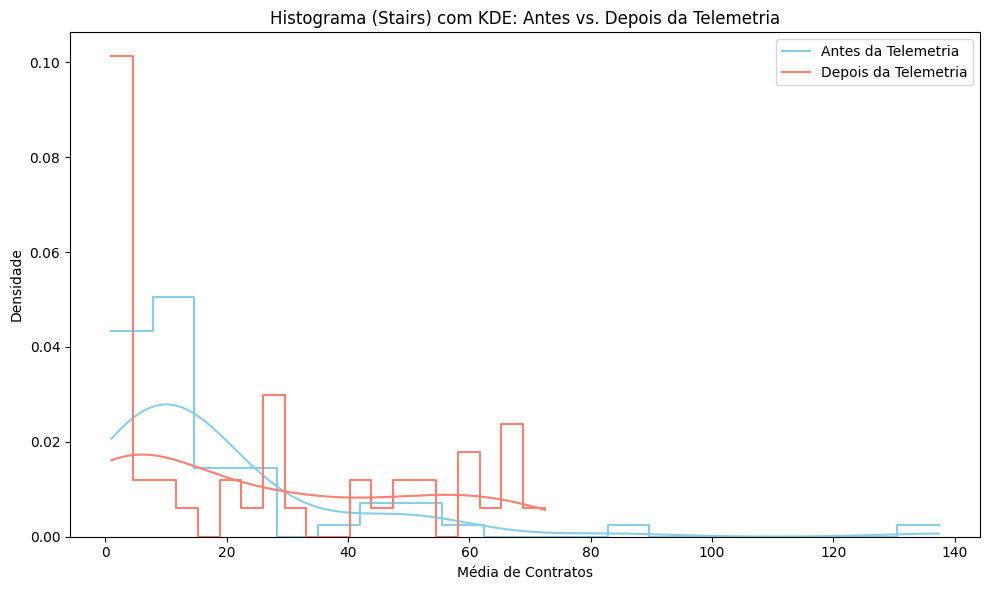

In [63]:
import pandas as pd

# Cópia do DataFrame original
df = df_contratos.copy()




mask = df['Data Conteúdo Personalizado'] != 0
df = df[mask]
# Converter as colunas para datetime
df['Data Conteúdo Personalizado	'] = pd.to_datetime(df['Data Conteúdo Personalizado'], errors='coerce', dayfirst=True)
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# --- Contratos ANTES da Telemetria ---
# Criar máscara para registros onde created_at é menor que Data Telemetria
mask_antes = df['created_at'] < df['Data Conteúdo Personalizado']
df_antes = df[mask_antes]

# Agrupar por company_id e mês (baseado em created_at)
contratos_mensais_antes = df_antes.groupby(
    ['company_id', pd.Grouper(key='created_at', freq='M')]
).size().reset_index(name='num_contratos')

# Calcular a média de contratos por mês para cada company_id (antes da telemetria)
media_antes = contratos_mensais_antes.groupby('company_id')['num_contratos'].mean().reset_index()
media_antes.rename(columns={'num_contratos': 'media_contratos_antes_conteudo'}, inplace=True)

# --- Contratos DEPOIS da Telemetria ---
# Criar máscara para registros onde created_at é maior que Data Telemetria 
# e Data Telemetria não é 1970-01-01 (valor inválido)
mask_depois = (df['created_at'] > df['Data Conteúdo Personalizado	'])
df_depois = df[mask_depois]

# Agrupar por company_id e mês (baseado em created_at)
contratos_mensais_depois = df_depois.groupby(
    ['company_id', pd.Grouper(key='created_at', freq='M')]
).size().reset_index(name='num_contratos')

# Calcular a média de contratos por mês para cada company_id (depois da telemetria)
media_depois = contratos_mensais_depois.groupby('company_id')['num_contratos'].mean().reset_index()
media_depois.rename(columns={'num_contratos': 'media_contratos_depois_conteudo'}, inplace=True)

# --- Unir os resultados ---
# Se alguma empresa tiver apenas contratos antes ou apenas depois, usaremos merge outer
media_contratos = pd.merge(media_antes, media_depois, on='company_id', how='outer')

# Visualizar resultados
display(media_contratos.head())
display(media_contratos.describe())
media_contratos_conteudo = media_contratos.copy()



import matplotlib.pyplot as plt
import seaborn as sns

# Remover NaNs, se houver
dados_antes = media_contratos['media_contratos_antes_conteudo'].dropna()
dados_depois = media_contratos['media_contratos_depois_conteudo'].dropna()

plt.figure(figsize=(10, 6))

# Plotar o histograma com KDE para "antes" utilizando o formato de stairs (step)
sns.histplot(
    dados_antes, 
    kde=True, 
    bins=20, 
    color='skyblue', 
    element='step',   # desenha como stairs
    fill=False,       # sem preenchimento
    stat="density",   # para normalizar e facilitar a comparação
    label='Antes da Telemetria'
)

# Plotar o histograma com KDE para "depois" utilizando o formato de stairs (step)
sns.histplot(
    dados_depois, 
    kde=True, 
    bins=20, 
    color='salmon', 
    element='step',   # desenha como stairs
    fill=False,       # sem preenchimento
    stat="density",   # para normalizar e facilitar a comparação
    label='Depois da Telemetria'
)

plt.xlabel('Média de Contratos')
plt.ylabel('Densidade')
plt.title('Histograma (Stairs) com KDE: Antes vs. Depois da Telemetria')
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
from scipy.stats import wilcoxon

df = media_contratos.copy()
df = df.dropna(axis=0)


dados_antes = df['media_contratos_antes_conteudo']
dados_depois = df['media_contratos_depois_conteudo']

# Aplicar o teste de Wilcoxon para amostras pareadas
stat, p_value = wilcoxon(data_antes, data_depois)

print("Estatística do teste de Wilcoxon:", stat)
print("p-valor:", p_value)


Estatística do teste de Wilcoxon: 234.0
p-valor: 0.0002824993571180473


In [65]:
media_contratos_conteudo = media_contratos.copy()

In [66]:
media_contratos_conteudo.head()

,company_id,media_contratos_antes_conteudo,media_contratos_depois_conteudo
0,34,14.241379,26.800000
1,36,83.255814,66.142857
2,88,9.727273,NaN
3,131,21.760000,23.000000
4,150,8.517241,1.500000


In [67]:
media_contratos_conteudo.head()

,company_id,media_contratos_antes_conteudo,media_contratos_depois_conteudo
0,34,14.241379,26.800000
1,36,83.255814,66.142857
2,88,9.727273,NaN
3,131,21.760000,23.000000
4,150,8.517241,1.500000


In [68]:
media_contratos_telemetria.head()

,company_id,media_contratos_antes_telemetria,media_contratos_depois_telemetria
0,27,27.115385,29.000000
1,34,13.862069,29.000000
2,131,19.047619,28.800000
3,150,9.037037,1.500000
4,159,28.500000,46.769231


In [69]:
media_contratos_geral = media_contratos_telemetria.merge(media_contratos_conteudo, on="company_id", how="right")

In [70]:
media_contratos_geral.head()

,company_id,media_contratos_antes_telemetria,media_contratos_depois_telemetria,media_contratos_antes_conteudo,media_contratos_depois_conteudo
0,34,13.862069,29.0,14.241379,26.800000
1,36,NaN,NaN,83.255814,66.142857
2,88,NaN,NaN,9.727273,NaN
3,131,19.047619,28.8,21.760000,23.000000
4,150,9.037037,1.5,8.517241,1.500000


In [71]:
media_contratos_geral["telemetria_aumentou"] =  media_contratos_geral["media_contratos_depois_telemetria"] > media_contratos_geral["media_contratos_antes_telemetria"]
media_contratos_geral["conteudo_aumentou"] =  media_contratos_geral["media_contratos_depois_conteudo"] > media_contratos_geral["media_contratos_antes_conteudo"]

In [72]:
media_contratos_geral["media_contratos_antes_conteudo"].mean()

np.float64(19.115391269948944)

In [73]:
((media_contratos_geral["media_contratos_depois_conteudo"].mean()
- media_contratos_geral["media_contratos_antes_conteudo"].mean()) /
media_contratos_geral["media_contratos_antes_conteudo"].mean()
)


np.float64(0.377804917715455)

In [74]:
((media_contratos_geral["media_contratos_depois_telemetria"].mean()
- media_contratos_geral["media_contratos_antes_telemetria"].mean()) /
media_contratos_geral["media_contratos_antes_telemetria"].mean()
)


np.float64(0.5575904340464193)

/tmp/ipykernel_50230/66088338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_id'] = df['company_id'].astype(str)


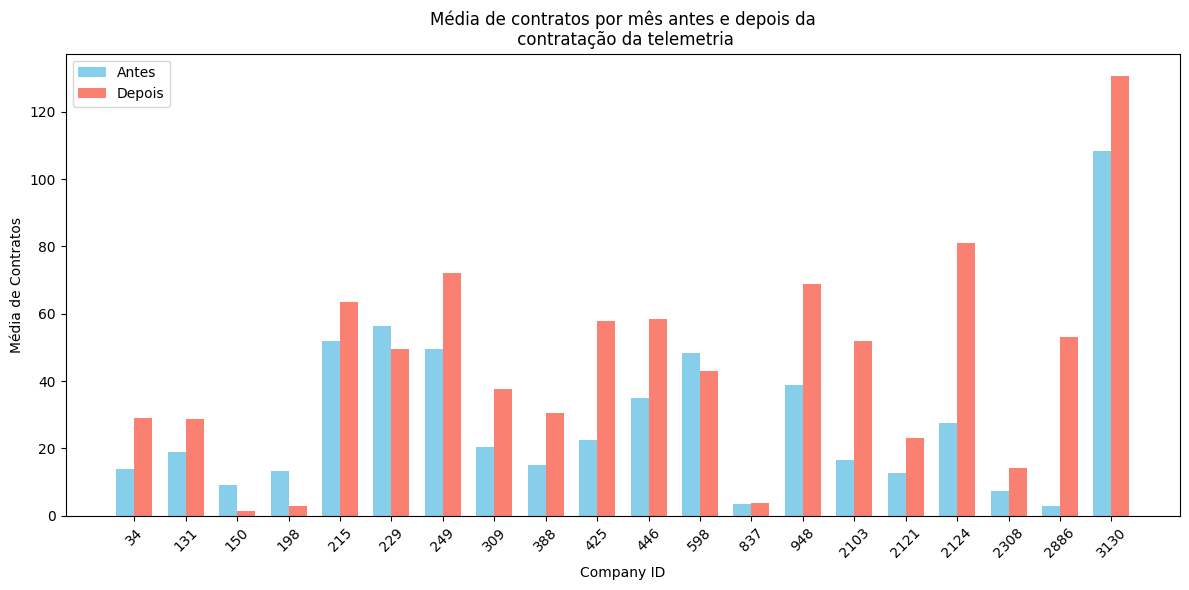

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que 'media_contratos' é o DataFrame com as colunas desejadas
# Remover linhas com NaN nas colunas de interesse
df = media_contratos_geral.dropna(subset=['media_contratos_antes_telemetria', 'media_contratos_depois_telemetria'])

# Converter company_id para string para exibição no eixo x
df['company_id'] = df['company_id'].astype(str)

# Posições para as barras
x_pos = np.arange(len(df))
bar_width = 0.35

plt.figure(figsize=(12, 6))

# Barras para "Antes"
plt.bar(x_pos - bar_width/2, df['media_contratos_antes_telemetria'], width=bar_width, 
        color='skyblue', label='Antes')

# Barras para "Depois"
plt.bar(x_pos + bar_width/2, df['media_contratos_depois_telemetria'], width=bar_width, 
        color='salmon', label='Depois')

# Configurar os ticks do eixo x com os IDs
plt.xticks(x_pos, df['company_id'], rotation=45)
plt.xlabel('Company ID')
plt.ylabel('Média de Contratos')
plt.title('Média de contratos por mês antes e depois da\n contratação da telemetria')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_50230/3698933533.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_id'] = df['company_id'].astype(str)


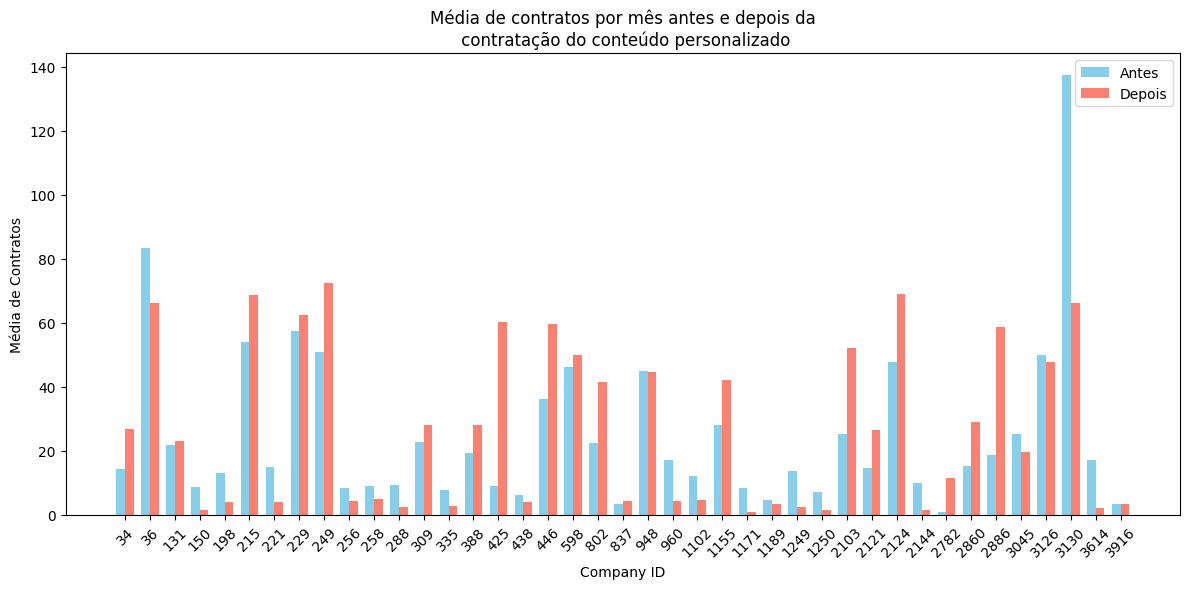

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que 'media_contratos' é o DataFrame com as colunas desejadas
# Remover linhas com NaN nas colunas de interesse
df = media_contratos_geral.dropna(subset=['media_contratos_antes_conteudo', 'media_contratos_depois_conteudo'])

# Converter company_id para string para exibição no eixo x
df['company_id'] = df['company_id'].astype(str)

# Posições para as barras
x_pos = np.arange(len(df))
bar_width = 0.35

plt.figure(figsize=(12, 6))

# Barras para "Antes"
plt.bar(x_pos - bar_width/2, df['media_contratos_antes_conteudo'], width=bar_width, 
        color='skyblue', label='Antes')

# Barras para "Depois"
plt.bar(x_pos + bar_width/2, df['media_contratos_depois_conteudo'], width=bar_width, 
        color='salmon', label='Depois')

# Configurar os ticks do eixo x com os IDs
plt.xticks(x_pos, df['company_id'], rotation=45)
plt.xlabel('Company ID')
plt.ylabel('Média de Contratos')
plt.title('Média de contratos por mês antes e depois da\n contratação do conteúdo personalizado')
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
media_contratos_geral

,company_id,media_contratos_antes_telemetria,media_contratos_depois_telemetria,media_contratos_antes_conteudo,media_contratos_depois_conteudo,telemetria_aumentou,conteudo_aumentou
0,34,13.862069,29.000000,14.241379,26.800000,True,True
1,36,NaN,NaN,83.255814,66.142857,False,False
2,88,NaN,NaN,9.727273,NaN,False,False
3,131,19.047619,28.800000,21.760000,23.000000,True,True
4,150,9.037037,1.500000,8.517241,1.500000,False,False
5,198,13.206897,3.000000,12.966667,4.000000,False,False
6,215,51.894737,63.500000,53.820513,68.500000,True,True
7,221,NaN,NaN,15.000000,4.000000,False,False
8,229,56.421053,49.500000,57.512821,62.500000,False,True
9,233,NaN,NaN,1.000000,NaN,False,False


In [78]:
media_contratos_geral["telemetria_aumentou"].sum() / media_contratos_geral["media_contratos_depois_telemetria"].dropna().shape[0]

np.float64(0.5714285714285714)

In [79]:
media_contratos_geral["conteudo_aumentou"].sum() / media_contratos_geral["media_contratos_depois_conteudo"].dropna().shape[0]

np.float64(0.40425531914893614)